In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

from scripts.stats import (test_moderation, interpret_moderation,
                           interpret_direct_effect, format_effect_with_stars)
import processing.scales as scales
import warnings
warnings.filterwarnings('ignore')

# define variable names
tia_scales = scales.tia_scales
hcsds_scales = scales.hcsds_scales
ati_scales = scales.ati_scales
manip_check_scales = scales.manip_check_scales

scale_titles = scales.scale_titles

'''
results = pd.DataFrame(columns=['indep', 'dep', 'mod',
                                #model stats
                                'n', 'r_squared', 'adj_r_squared',
                                # main effect of independent variable
                                'coeff_indep', 'se_indep', 'p_indep', 'ci_low_indep', 'ci_high_indep',
                                # main effect of moderator variable
                                'coeff_mod', 'se_mod', 'p_mod', 'ci_low_mod', 'ci_high_mod',
                                # interaction effect (moderation effect)
                                'coeff_int', 'se_int', 'p_int', 'ci_low_int', 'ci_high_int'])
'''

plots_path = '../plots/multivariate_analysis/'

# Load data
data = pd.read_csv('../data/data_scales.csv')
print(f"Total sample size: {len(data)}")
print(f"\nGroup distribution:")
print(data['stimulus_group'].value_counts())

Total sample size: 255

Group distribution:
stimulus_group
1    129
0    126
Name: count, dtype: int64


## 1. Data Preparation

### Variable Centering and Coding

We prepare variables for moderation analysis:

1. **Effect code treatment**: stimulus_group as -0.5 (control) and 0.5 (uncertainty)
2. **Standardize continuous variables**: For better comparison of beta values between variables
3. **Effect code categorical variables**: For symmetric interpretation

In [2]:
# 1. Effect code treatment: control = -0.5, uncertainty = 0.5
data['group_effect'] = data['stimulus_group'] - 0.5

# 2. Normalize all continuous variables
continuous_vars = hcsds_scales + ati_scales + tia_scales + ['age', 'page_submit']

for var in continuous_vars:
    data[f'{var}_c'] = (data[var] - data[var].mean())/data[var].std()

# 3. Effect code gender: male (1) = 0.5, female (2) = -0.5, "other/prefer not to say" (3) = 0
data['gender_c'] = data['gender'].map({1: 0.5, 2: -0.5, 3: 0})

# 4. Mean-center ordinal variables (education, AI experience)
data['education_c'] = data['education'] - data['education'].mean()
data['Q19_c'] = data['Q19'] - data['Q19'].mean()

print(f"Prepared {len(data)} observations for analysis")
print(f"Continuous moderators: {len(continuous_vars)}")
print(f"Total moderators to test: {len(continuous_vars) + 3}")  # + gender, education, Q19

Prepared 255 observations for analysis
Continuous moderators: 10
Total moderators to test: 13


## 2. Descriptive Statistics

Before running inferential tests, examine the data:
- Means, SDs, and ranges for each trust subscale by experimental condition
- Correlation matrix for the 5 TiA subscales (to see how they relate)
- Sample sizes per group

**Note**: We use the 5 core TiA subscales as DVs: `tia_f`, `tia_pro`, `tia_rc`, `tia_t`, `tia_up`

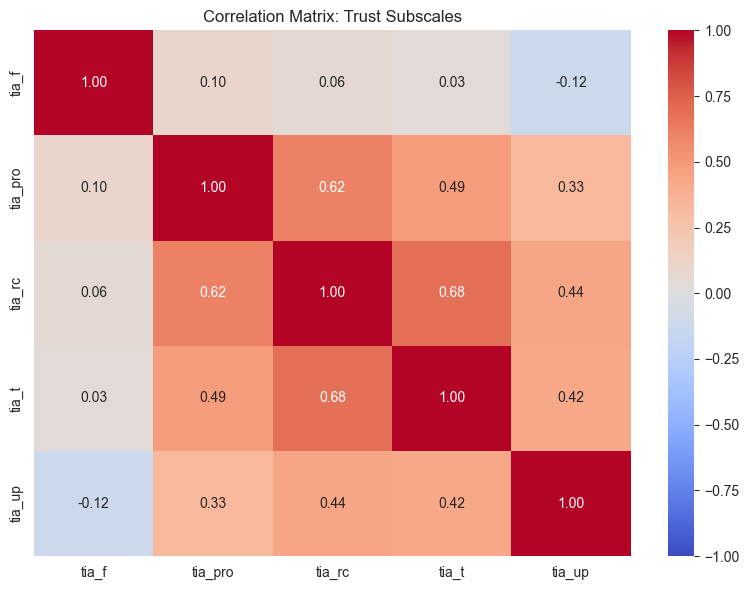

In [4]:
# Define the 5 core TiA subscales as dependent variables
dvs = tia_scales

# Correlation matrix for DVs: Shows how the 5 trust subscales relate to each other
corr_matrix = data[dvs].corr()

# Visualize with heatmap
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            vmin=-1, vmax=1, fmt='.2f')
plt.title('Correlation Matrix: Trust Subscales')
plt.tight_layout()
plt.savefig(f'{plots_path}corr_matrix.png')
plt.show()

## 3. Assumption Checks

MANOVA assumptions to verify:
1. **Univariate normality** - Shapiro-Wilk test + visual inspection (histograms, Q-Q plots)
2. **Multivariate outliers** - Mahalanobis distance (flag cases with p < .001)
3. **Homogeneity of covariance matrices** - Box's M test (if violated, use Pillai's Trace instead of Wilks' Lambda)
4. **Multicollinearity** - VIF for predictors (should be < 10, especially after adding interactions)

tia_f: W = 0.907, p = 0.000
tia_pro: W = 0.964, p = 0.000
tia_rc: W = 0.960, p = 0.000
tia_t: W = 0.942, p = 0.000
tia_up: W = 0.978, p = 0.001
Multivariate outliers (p < .001): 1
       Variable       VIF
1  group_effect  1.008038
2         age_c  1.042640
3   education_c  1.076576
4         ati_c  1.011195
5     hcsds_c_c  1.611826
6     hcsds_v_c  1.553500


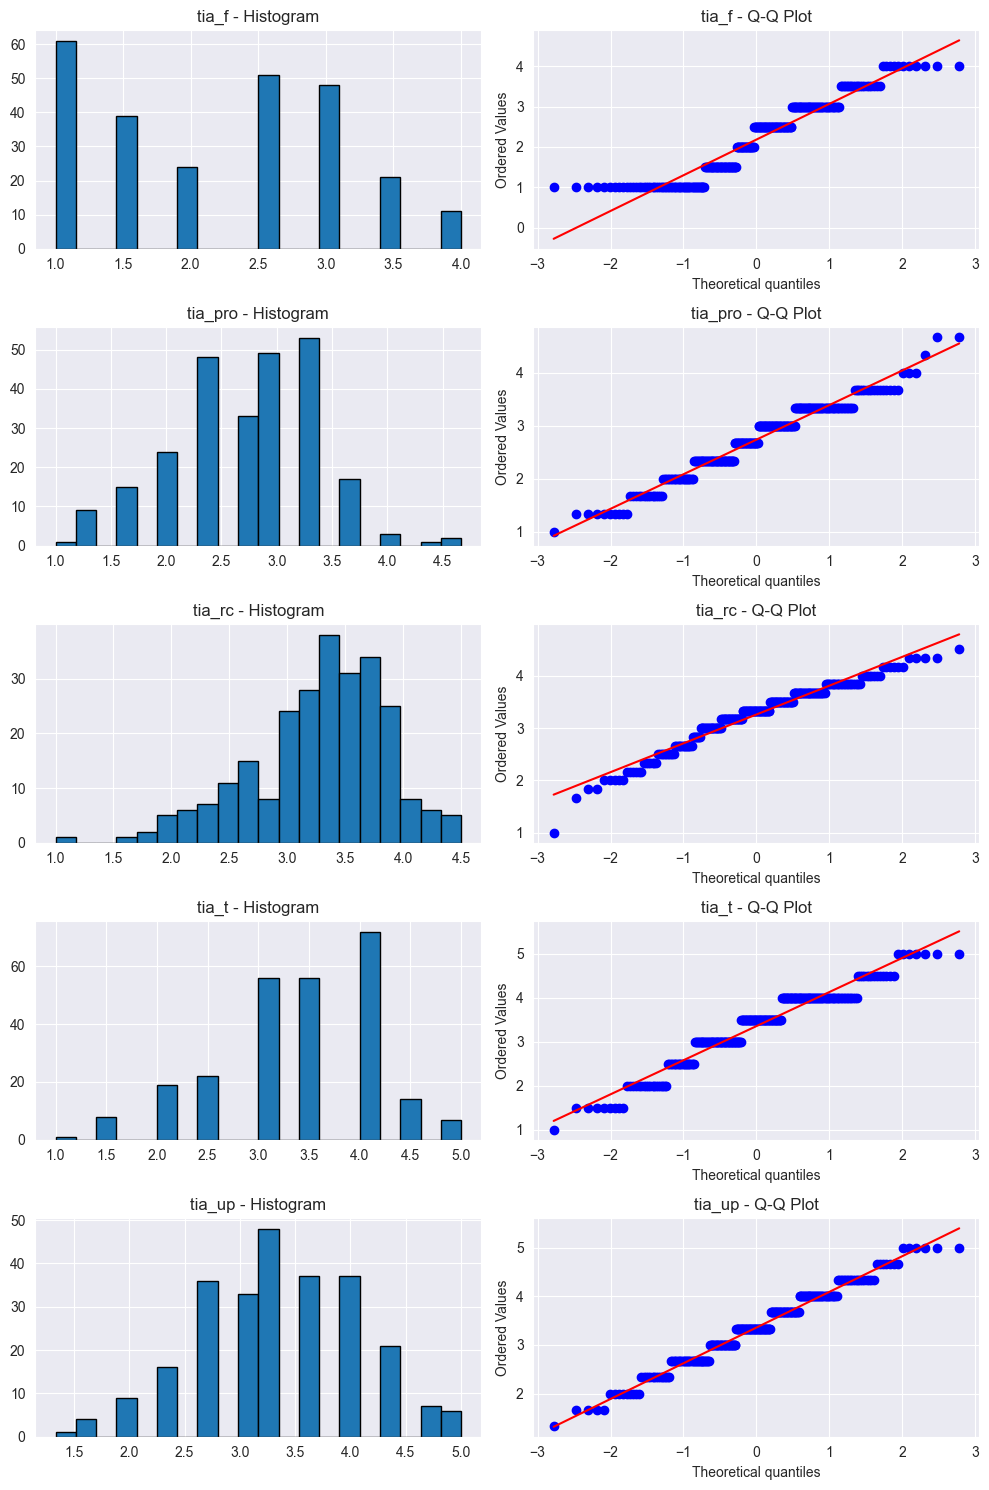

In [8]:
from scipy import stats
from scipy.spatial.distance import mahalanobis
from statsmodels.stats.outliers_influence import variance_inflation_factor

# --- 3.1 Univariate Normality ---
# Shapiro-Wilk test for each DV (p < .05 suggests non-normality)
for dv in dvs:
    stat, p = stats.shapiro(data[dv])
    print(f"{dv}: W = {stat:.3f}, p = {p:.3f}")

# Visual: Histograms with Q-Q plots
fig, axes = plt.subplots(len(dvs), 2, figsize=(10, 3*len(dvs)))
for i, dv in enumerate(dvs):
    axes[i, 0].hist(data[dv], bins=20, edgecolor='black')
    axes[i, 0].set_title(f'{dv} - Histogram')
    stats.probplot(data[dv], plot=axes[i, 1])
    axes[i, 1].set_title(f'{dv} - Q-Q Plot')
plt.tight_layout()

# --- 3.2 Multivariate Outliers (Mahalanobis Distance) ---
def calc_mahalanobis(df, vars):
    """Calculate Mahalanobis distance for each observation."""
    X = df[vars].values
    mean = np.mean(X, axis=0)
    cov = np.cov(X.T)
    cov_inv = np.linalg.inv(cov)
    distances = [mahalanobis(x, mean, cov_inv) for x in X]
    return distances

data['mahal_dist'] = calc_mahalanobis(data, dvs)
data['mahal_p'] = 1 - stats.chi2.cdf(data['mahal_dist']**2, df=len(dvs))
outliers = data[data['mahal_p'] < 0.001]
print(f"Multivariate outliers (p < .001): {len(outliers)}")

# --- 3.3 Homogeneity of Covariance (Box's M) ---
# Note: Box's M is sensitive to non-normality. If significant, use Pillai's Trace.
def boxs_m_test(data, dvs, group_var):
    """Manual Box's M test implementation."""
    # This is complex - consider using pingouin.box_m() or
    # just note to use Pillai's Trace if in doubt
    pass

# Alternative: Just use Pillai's Trace (more robust) by default

# --- 3.4 Multicollinearity (VIF) ---
# Check VIF for predictors in the full model
predictors = ['group_effect', 'age_c', 'education_c', 'ati_c', 'hcsds_c_c', 'hcsds_v_c']
X = data[predictors]
X = sm.add_constant(X)
vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data[vif_data['Variable'] != 'const'])

## 4. Hierarchical MANOVA Models

Build four sequential models to test:
1. **Model 1**: Experimental condition only (primary hypothesis)
2. **Model 2**: + Demographics (age, education)
3. **Model 3**: + Psychometric scales (ATI, HCSDS competence, HCSDS values)
4. **Model 4**: + Interactions (moderation tests: condition × each predictor)

Use `statsmodels.multivariate.manova.MANOVA` for multivariate tests.

In [67]:
from statsmodels.multivariate.manova import MANOVA

# Define DV string for MANOVA formula
dv_formula = ' + '.join(dvs)  # 'tia_f + tia_pro + tia_rc + tia_t + tia_up'

manova_models = [0] *4

# --- Model 1: Condition only ---
formula_m1 = f'{dv_formula} ~ group_effect'
manova_models[0] = MANOVA.from_formula(formula_m1, data=data)
print("Model 1: Condition only")
print(manova_models[0].mv_test(skip_intercept_test=True))

# --- Model 2: + Demographics ---
formula_m2 = f'{dv_formula} ~ group_effect + age_c + education_c + gender_c + Q19_c'
manova_models[1] = MANOVA.from_formula(formula_m2, data=data)
print("\nModel 2: + Demographics")
print(manova_models[1].mv_test(skip_intercept_test=True))

# --- Model 3: + Psychometric scales ---
formula_m3 = f'{dv_formula} ~ group_effect + age_c + education_c + gender_c + Q19_c + ati_c + hcsds_c_c + hcsds_v_c'
manova_models[2] = MANOVA.from_formula(formula_m3, data=data)
print("\nModel 3: + Psychometric scales")
print(manova_models[2].mv_test(skip_intercept_test=True))

# --- Model 4: + Interactions (moderation) ---
# Note: statsmodels formula syntax uses ':' for interactions
formula_m4 = f'''{dv_formula} ~ group_effect + age_c + education_c + gender_c + Q19_c + ati_c + hcsds_c_c + hcsds_v_c
                 + group_effect:age_c + group_effect:education_c  + group_effect:gender_c
                 + group_effect:ati_c + group_effect:hcsds_c_c + group_effect:hcsds_v_c'''
manova_models[3] = MANOVA.from_formula(formula_m4, data=data)
print("\nModel 4: + Interactions")
print(manova_models[3].mv_test(skip_intercept_test=True))

Model 1: Condition only
                  Multivariate linear model
                                                             
-------------------------------------------------------------
      group_effect      Value  Num DF  Den DF  F Value Pr > F
-------------------------------------------------------------
          Wilks' lambda 0.9801 5.0000 249.0000  1.0128 0.4106
         Pillai's trace 0.0199 5.0000 249.0000  1.0128 0.4106
 Hotelling-Lawley trace 0.0203 5.0000 249.0000  1.0128 0.4106
    Roy's greatest root 0.0203 5.0000 249.0000  1.0128 0.4106


Model 2: + Demographics
                  Multivariate linear model
                                                             
-------------------------------------------------------------
      group_effect      Value  Num DF  Den DF  F Value Pr > F
-------------------------------------------------------------
          Wilks' lambda 0.9768 5.0000 245.0000  1.1634 0.3278
         Pillai's trace 0.0232 5.0000 245.0000  1.1634 0

## 5. Extract Multivariate Test Statistics

From each MANOVA model, extract:
- **Pillai's Trace** (robust to violations of homogeneity)
- **Wilks' Lambda** (traditional, but sensitive to violations)
- **F-statistic**, degrees of freedom, p-value
- **Partial η²** (effect size)

Compare models to assess incremental variance explained.

In [53]:
# --- Extract test statistics from MANOVA results ---
# The mv_test() method returns a MultivariateTestResults object
# Access specific tests via: result.results['effect_name']['stat']

mv_results = []

for (i, model) in enumerate(manova_models):
    r = model.mv_test()
    print(f'=== MANOVA model {i + 1} ===')

    # go through all effects
    for effect in r.results:
        if not effect == 'Intercept':
            print(f"\n=== {effect} ===")
            result_df = r.results[effect]['stat']
            pillai = result_df.loc["Pillai's trace"]

            print(f"Pillai's Trace = {pillai['Value']:.4f}")
            print(f"F({pillai['Num DF']:.0f}, {pillai['Den DF']:.0f}) = {pillai['F Value']:.3f}")

            # Calculate partial η² for multivariate effect
            partial_eta_sq = (pillai['F Value'] * pillai['Num DF']) / (pillai['F Value'] * pillai['Num DF'] + pillai['Den DF'])
            print(f"Partial eta2 = {partial_eta_sq:.4f}")

            # Calculate p-value and show marker for significance
            p = pillai['Pr > F']
            sig = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else ''

            print(f"p = {p:.4f} {sig}")

            mv_results.append({
                'model': (i+1),
                'effect': effect,
                'pillai value': pillai['Value'],
                'F Value': pillai['F Value'],
                'Num DF': pillai['Num DF'],
                'Den DF': pillai['Den DF'],
                'partial_eta_sq': partial_eta_sq,
                'p': p,
                'sig': sig if not sig == '' else 'not significant'
            })

    print(f'\n{'='*22}\n\n')

mv_results_df = pd.DataFrame(mv_results)

=== MANOVA model 1 ===

=== group_effect ===
Pillai's Trace = 0.0199
F(5, 249) = 1.013
Partial eta2 = 0.0199
p = 0.4106 



=== MANOVA model 2 ===

=== group_effect ===
Pillai's Trace = 0.0232
F(5, 245) = 1.163
Partial eta2 = 0.0232
p = 0.3278 

=== age_c ===
Pillai's Trace = 0.1667
F(5, 245) = 9.803
Partial eta2 = 0.1667
p = 0.0000 ***

=== education_c ===
Pillai's Trace = 0.0774
F(5, 245) = 4.109
Partial eta2 = 0.0774
p = 0.0013 **

=== gender_c ===
Pillai's Trace = 0.0180
F(5, 245) = 0.897
Partial eta2 = 0.0180
p = 0.4834 

=== Q19_c ===
Pillai's Trace = 0.0824
F(5, 245) = 4.399
Partial eta2 = 0.0824
p = 0.0007 ***



=== MANOVA model 3 ===

=== group_effect ===
Pillai's Trace = 0.0217
F(5, 242) = 1.074
Partial eta2 = 0.0217
p = 0.3752 

=== age_c ===
Pillai's Trace = 0.1843
F(5, 242) = 10.938
Partial eta2 = 0.1843
p = 0.0000 ***

=== education_c ===
Pillai's Trace = 0.0724
F(5, 242) = 3.780
Partial eta2 = 0.0724
p = 0.0026 **

=== gender_c ===
Pillai's Trace = 0.0117
F(5, 242) = 0.

In [54]:
# show (almost) significant results
# mv_results_df[mv_results_df['p'] < 0.1]

for i, row in mv_results_df[mv_results_df['p'] < 0.1].iterrows():
    print(f'Model {row['model']}: {row['effect']}\n partial_eta2 = {row['partial_eta_sq']:.4f}  p = {row['p']:.4f} ({row['sig']})\n')

Model 2: age_c
 partial_eta2 = 0.1667  p = 0.0000 (***)

Model 2: education_c
 partial_eta2 = 0.0774  p = 0.0013 (**)

Model 2: Q19_c
 partial_eta2 = 0.0824  p = 0.0007 (***)

Model 3: age_c
 partial_eta2 = 0.1843  p = 0.0000 (***)

Model 3: education_c
 partial_eta2 = 0.0724  p = 0.0026 (**)

Model 3: Q19_c
 partial_eta2 = 0.0726  p = 0.0025 (**)

Model 3: ati_c
 partial_eta2 = 0.0877  p = 0.0005 (***)

Model 3: hcsds_c_c
 partial_eta2 = 0.0653  p = 0.0057 (**)

Model 4: age_c
 partial_eta2 = 0.1854  p = 0.0000 (***)

Model 4: education_c
 partial_eta2 = 0.0689  p = 0.0046 (**)

Model 4: Q19_c
 partial_eta2 = 0.0725  p = 0.0031 (**)

Model 4: ati_c
 partial_eta2 = 0.0915  p = 0.0004 (***)

Model 4: hcsds_c_c
 partial_eta2 = 0.0625  p = 0.0091 (**)



## 6. Univariate Follow-up Tests (OLS Regression)

For significant multivariate effects, run OLS regression for each trust subscale to:
- Get unstandardized (B) and standardized (β) coefficients
- Extract 95% confidence intervals
- Report t-statistics and p-values
- Calculate R² for each subscale

This gives the detailed picture of *which* trust dimensions are affected.

In [56]:
# --- Run OLS for each DV ---
# Use the same predictors as the MANOVA model you want to follow up

# Follow-up on Model 3 (no interactions)
# look at following scales which were significant in multivariate test:
predictors = 'group_effect + age_c + education_c + Q19_c + ati_c + hcsds_c_c'

univariate_results = {}
for dv in dvs:
    formula = f'{dv} ~ {predictors}'
    model = smf.ols(formula, data=data).fit()
    univariate_results[dv] = model

    print(f"\n{'='*60}")
    print(f"DV: {dv} ({scale_titles.get(dv, dv)})")
    print(f"{'='*60}")
    print(f"R² = {model.rsquared:.4f}, Adj. R² = {model.rsquared_adj:.4f}")
    print(f"F({model.df_model:.0f}, {model.df_resid:.0f}) = {model.fvalue:.3f}, p = {model.f_pvalue:.4f}")
    print("\nCoefficients:")
    print(model.summary().tables[1])

# --- Extract coefficients and CIs into DataFrame ---
def extract_ols_results(model, predictor):
    """Extract key stats for a specific predictor."""
    return {
        'B': model.params[predictor],
        'SE': model.bse[predictor],
        't': model.tvalues[predictor],
        'p': model.pvalues[predictor],
        'CI_lower': model.conf_int().loc[predictor, 0],
        'CI_upper': model.conf_int().loc[predictor, 1]
    }

# Build results table for group_effect across all DVs
group_effects = []
for dv, model in univariate_results.items():
    result = extract_ols_results(model, 'group_effect')
    result['DV'] = dv
    group_effects.append(result)
group_effects_df = pd.DataFrame(group_effects)
print("\nGroup effect (condition) across all trust subscales:")
print(group_effects_df)


DV: tia_f (TiA - Familiarity)
R² = 0.1188, Adj. R² = 0.0975
F(6, 248) = 5.573, p = 0.0000

Coefficients:
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.1815      0.055     39.921      0.000       2.074       2.289
group_effect     0.1418      0.110      1.287      0.199      -0.075       0.359
age_c            0.1814      0.063      2.860      0.005       0.057       0.306
education_c      0.0715      0.040      1.769      0.078      -0.008       0.151
Q19_c            0.0616      0.059      1.045      0.297      -0.055       0.178
ati_c            0.2201      0.057      3.891      0.000       0.109       0.332
hcsds_c_c       -0.0715      0.057     -1.265      0.207      -0.183       0.040

DV: tia_pro (TiA - Propensity to Trust)
R² = 0.0982, Adj. R² = 0.0764
F(6, 248) = 4.500, p = 0.0002

Coefficients:
                   coef    std err          t    

## 7. Non-Inferiority Testing (Primary Hypothesis)

The primary hypothesis is that the uncertainty condition (group=1) is **not worse** than control for trust outcomes. This is a one-sided test:

- **H₀**: μ_uncertainty - μ_control ≤ -Δ (uncertainty is inferior)
- **H₁**: μ_uncertainty - μ_control > -Δ (uncertainty is non-inferior)

Where Δ is the **non-inferiority margin** (the largest acceptable decrease).

**Non-inferiority margin**: We use the Minimum Detectable Effect (MDE) based on our sample's power, following the approach from the main effects analysis.

**Interpretation**:
- If the lower bound of the 95% CI is above -Δ → non-inferiority established
- If the lower bound is below -Δ → cannot conclude non-inferiority

Non-inferiority margins (MDE, regression-based):
  tia_f: 0.310
  tia_pro: 0.225
  tia_rc: 0.183
  tia_t: 0.254
  tia_up: 0.259

Non-Inferiority Test Results for 'TiA - Familiarity':
  Mean difference: M_diff = 0.142, SE = 0.110
  95% CI: [-0.074, 0.358]
  SESOI margin: -0.310
  z = 4.100, p < .001
  Result: Non-inferiority established (p < .001)


Non-Inferiority Test Results for 'TiA - Propensity to Trust':
  Mean difference: M_diff = -0.054, SE = 0.080
  95% CI: [-0.211, 0.103]
  SESOI margin: -0.225
  z = 2.135, p = .016
  Result: Non-inferiority established (p = .016)


Non-Inferiority Test Results for 'TiA - Reliability/Competence':
  Mean difference: M_diff = -0.100, SE = 0.065
  95% CI: [-0.228, 0.027]
  SESOI margin: -0.183
  z = 1.269, p = .102
  Result: Non-inferiority not established (p = .102)


Non-Inferiority Test Results for 'TiA - Trust in Automation':
  Mean difference: M_diff = -0.102, SE = 0.090
  95% CI: [-0.279, 0.075]
  SESOI margin: -0.254
  z = 1.688, p = .046


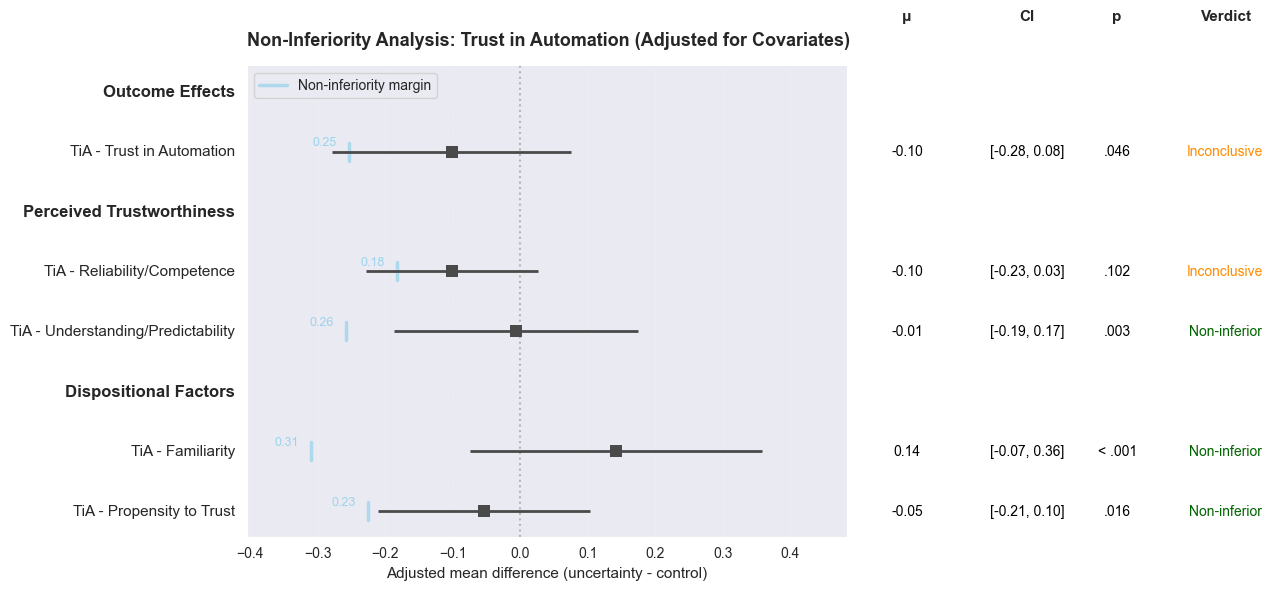


Non-Inferiority Test Summary (Regression-Based)
Note: All values adjusted for covariates: group_effect + age_c + education_c + Q19_c + ati_c + hcsds_c_c

TiA - Familiarity:
  B = 0.142, SE = 0.110, 95% CI [-0.075, 0.359]
  Non-inferiority margin = 0.310
  Lower CI (-0.075) > -0.310? ✓ Non-inferior

TiA - Propensity to Trust:
  B = -0.054, SE = 0.080, 95% CI [-0.212, 0.104]
  Non-inferiority margin = 0.225
  Lower CI (-0.212) > -0.225? ✓ Non-inferior

TiA - Reliability/Competence:
  B = -0.100, SE = 0.065, 95% CI [-0.228, 0.028]
  Non-inferiority margin = 0.183
  Lower CI (-0.228) > -0.183? ✗ Inconclusive

TiA - Trust in Automation:
  B = -0.102, SE = 0.090, 95% CI [-0.279, 0.076]
  Non-inferiority margin = 0.254
  Lower CI (-0.279) > -0.254? ✗ Inconclusive

TiA - Understanding/Predictability:
  B = -0.006, SE = 0.092, 95% CI [-0.187, 0.175]
  Non-inferiority margin = 0.259
  Lower CI (-0.187) > -0.259? ✓ Non-inferior



In [60]:
from scripts.viz_utils import plot_noninferiority_test
from scipy import stats as scipy_stats

# --- Calculate non-inferiority margins using regression-based SE ---
# This ensures consistency: margin, mean difference, and CI all come from the same model
alpha = 0.05
power = 0.80
beta = 1 - power

# Calculate MDE (non-inferiority margin) for each DV using regression SE
ni_margin = {}

for dv in dvs:
    model = univariate_results[dv]
    reg_se = model.bse['group_effect']  # SE from regression
    df = model.df_resid                  # Residual degrees of freedom
    
    # Critical t-values (using regression df)
    t_alpha = scipy_stats.t.ppf(1 - alpha/2, df)
    t_beta = scipy_stats.t.ppf(1 - beta, df)
    
    # MDE = (t_α/2 + t_β) × SE
    ni_margin[dv] = (t_alpha + t_beta) * reg_se

print("Non-inferiority margins (MDE, regression-based):")
for dv in dvs:
    print(f"  {dv}: {ni_margin[dv]:.3f}")

# --- Extract mean differences and SEs from univariate models ---
mean_diffs = [univariate_results[dv].params['group_effect'] for dv in dvs]
ses = [univariate_results[dv].bse['group_effect'] for dv in dvs]

# --- Plot non-inferiority test ---
categories = {
    'Outcome Effects': ['tia_t'],
    'Perceived Trustworthiness': ['tia_rc', 'tia_up'],
    'Dispositional Factors': ['tia_f', 'tia_pro']
}

fig, ax = plt.subplots(figsize=(12, 8))
plot_noninferiority_test(
    mean_diff=mean_diffs,
    sesoi=[ni_margin[dv] for dv in dvs],
    se=ses,
    alpha=alpha,
    variable_names=dvs,
    variable_labels=scale_titles,
    title='Non-Inferiority Analysis: Trust in Automation (Adjusted for Covariates)',
    xlabel='Adjusted mean difference (uncertainty - control)',
    categories=categories,
    category_order=['Outcome Effects', 'Perceived Trustworthiness', 'Dispositional Factors'],
    ax=ax
)

plt.tight_layout()
plt.savefig(f'{plots_path}noninferiority_test.png', transparent=True)
plt.show()

# --- Print summary ---
print("\n" + "="*70)
print("Non-Inferiority Test Summary (Regression-Based)")
print("="*70)
print(f"Note: All values adjusted for covariates: {predictors}")
print()

for i, dv in enumerate(dvs):
    model = univariate_results[dv]
    mean_diff = mean_diffs[i]
    se = ses[i]
    df = model.df_resid
    
    # Use t-distribution for CI (more accurate than z=1.96)
    t_crit = scipy_stats.t.ppf(1 - alpha/2, df)
    ci_lower = mean_diff - t_crit * se
    ci_upper = mean_diff + t_crit * se
    margin = ni_margin[dv]
    
    # Non-inferiority: lower CI bound > -margin
    is_noninferior = ci_lower > -margin
    status = "✓ Non-inferior" if is_noninferior else "✗ Inconclusive"
    
    print(f"{scale_titles.get(dv, dv)}:")
    print(f"  B = {mean_diff:.3f}, SE = {se:.3f}, 95% CI [{ci_lower:.3f}, {ci_upper:.3f}]")
    print(f"  Non-inferiority margin = {margin:.3f}")
    print(f"  Lower CI ({ci_lower:.3f}) > -{margin:.3f}? {status}")
    print()

## 8. Moderation Analysis Summary

Moderation effects were tested in MANOVA Model 4 by including interaction terms between experimental condition and potential moderators. **No significant moderation effects were found.**

This means the effect of uncertainty communication on trust does not depend on:
- Demographics (age, education, gender)
- Prior AI experience
- Technology affinity (ATI)
- Healthcare system trust (HCSDS)

In [64]:
# --- Moderation Analysis Summary ---
# All interaction terms were tested in MANOVA Model 4.
# Results extracted from multivariate analysis:

interaction_results = {
    'group_effect:age_c': {'Pillai': 0.0217, 'F': 1.049, 'p': 0.3898},
    'group_effect:education_c': {'Pillai': 0.0216, 'F': 1.040, 'p': 0.3948},
    'group_effect:gender_c': {'Pillai': 0.0165, 'F': 0.793, 'p': 0.5557},
    'group_effect:ati_c': {'Pillai': 0.0044, 'F': 0.207, 'p': 0.9592},
    'group_effect:hcsds_c_c': {'Pillai': 0.0297, 'F': 1.447, 'p': 0.2082},
    'group_effect:hcsds_v_c': {'Pillai': 0.0247, 'F': 1.198, 'p': 0.3110},
}

print("="*70)
print("Moderation Effects: MANOVA Model 4 Results")
print("="*70)
print(f"{'Interaction':<30} {'Pillai V':>10} {'F':>10} {'p':>10}")
print("-"*70)

for interaction, stats in interaction_results.items():
    # Clean up interaction name for display
    mod_name = interaction.replace('group_effect:', 'Condition × ').replace('_c', '')
    print(f"{mod_name:<30} {stats['Pillai']:>10.4f} {stats['F']:>10.3f} {stats['p']:>10.4f}")

print("-"*70)
print("\nConclusion: No significant moderation effects (all p > .05).")
print("The effect of uncertainty communication on trust is consistent")
print("across different levels of age, education, gender, ATI, and healthcare trust.")

Moderation Effects: MANOVA Model 4 Results
Interaction                      Pillai V          F          p
----------------------------------------------------------------------
Condition × age                    0.0217      1.049     0.3898
Condition × education              0.0216      1.040     0.3948
Condition × gender                 0.0165      0.793     0.5557
Condition × ati                    0.0044      0.207     0.9592
Condition × hcsds                  0.0297      1.447     0.2082
Condition × hcsds_v                0.0247      1.198     0.3110
----------------------------------------------------------------------

Conclusion: No significant moderation effects (all p > .05).
The effect of uncertainty communication on trust is consistent
across different levels of age, education, gender, ATI, and healthcare trust.


## 9. Results Tables & Visualizations

### Tables to Create:
1. **Table 1**: Descriptive statistics (means, SDs by condition)
2. **Table 2**: Correlation matrix for trust subscales
3. **Table 3**: Multivariate test results (Pillai's Trace for all models)
4. **Table 4**: Univariate coefficients for group effect across subscales
5. **Table 5**: Significant covariate effects (age, education, ATI, etc.)

### Visualizations:
- Correlation heatmap (Section 2)
- Non-inferiority forest plot (Section 7)

*Note: No interaction/moderation plots needed as no significant moderations were found.*

In [65]:
# --- Table 1: Descriptive Statistics ---
def create_descriptives_table(data, dvs, group_var='stimulus_group'):
    """Create APA-style descriptive statistics table."""
    desc = data.groupby(group_var)[dvs].agg(['mean', 'std', 'count'])
    return desc

table1 = create_descriptives_table(data, dvs)
print("Table 1: Descriptive Statistics by Condition")
print(table1.round(3))

# --- Table 2: Correlation Matrix ---
table2 = data[dvs].corr()
print("\nTable 2: Correlation Matrix for Trust Subscales")
print(table2.round(3))

# --- Table 3: Multivariate Test Results (Group Effect across models) ---
print("\nTable 3: Multivariate Test Results - Group Effect")
print("-"*60)
group_effect_mv = mv_results_df[mv_results_df['effect'] == 'group_effect'][
    ['model', 'pillai value', 'F Value', 'Num DF', 'Den DF', 'p', 'sig']
]
print(group_effect_mv.to_string(index=False))

# --- Table 4: Univariate Coefficients for Group Effect ---
def create_coefficients_table(univariate_results, predictor='group_effect'):
    """Create table of coefficients across all DVs."""
    rows = []
    for dv, model in univariate_results.items():
        row = {
            'DV': scale_titles.get(dv, dv),
            'B': model.params[predictor],
            'SE': model.bse[predictor],
            '95% CI': f"[{model.conf_int().loc[predictor, 0]:.3f}, {model.conf_int().loc[predictor, 1]:.3f}]",
            't': model.tvalues[predictor],
            'p': model.pvalues[predictor],
        }
        rows.append(row)
    return pd.DataFrame(rows)

table4 = create_coefficients_table(univariate_results, 'group_effect')
print("\nTable 4: Univariate Results - Condition Effect (Group Effect)")
print(table4.to_string(index=False))

# --- Table 5: Significant Covariate Effects ---
print("\nTable 5: Significant Covariate Effects (p < .05)")
print("-"*70)
sig_covariates = mv_results_df[
    (mv_results_df['effect'] != 'group_effect') & 
    (mv_results_df['p'] < 0.05) &
    (~mv_results_df['effect'].str.contains(':'))  # Exclude interactions
][['model', 'effect', 'pillai value', 'partial_eta_sq', 'p', 'sig']]
print(sig_covariates.to_string(index=False))

# --- Save tables ---
table1.to_csv(f'{plots_path}table1_descriptives.csv')
table2.to_csv(f'{plots_path}table2_correlations.csv')
table4.to_csv(f'{plots_path}table4_group_effects.csv')
# table5.to_csv(f'{plots_path}table4_group_effects.csv')

Table 1: Descriptive Statistics by Condition
                tia_f              tia_pro              tia_rc               \
                 mean    std count    mean    std count   mean    std count   
stimulus_group                                                                
0               2.107  0.900   126   2.751  0.682   126  3.308  0.558   126   
1               2.256  0.934   129   2.721  0.640   129  3.211  0.556   129   

                tia_t              tia_up               
                 mean    std count   mean    std count  
stimulus_group                                          
0               3.401  0.808   126  3.352  0.766   126  
1               3.314  0.778   129  3.359  0.707   129  

Table 2: Correlation Matrix for Trust Subscales
         tia_f  tia_pro  tia_rc  tia_t  tia_up
tia_f    1.000    0.096   0.057  0.035  -0.121
tia_pro  0.096    1.000   0.617  0.489   0.331
tia_rc   0.057    0.617   1.000  0.684   0.442
tia_t    0.035    0.489   0.684  1.00